In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, train_surrogate_tree, plot_surrogate_tree,\
                           extract_rules, print_rules, evaluate_generated_data,\
                           evaluate, plot_tree_leafs_2d, plot_diro2c_2d, get_surrogate_tree,\
                           get_feature_importances, plot_feature_importances
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity
from tasks.feature_ignored import make_task

In [2]:
clf_a, clf_b, X, y, feature_names, feature_precisions = make_task()

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Explanations

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

In [5]:
global_fidelities = {}
local_fidelities = {}
complexities = {}

## $(0,1)$

In [6]:
focus_class = '(0, 1)'
focus_class_idx = list(comparer.class_names).index(focus_class)

In [6]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump((explainer, explanation), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 6min 43s, sys: 3.08 s, total: 6min 47s
Wall time: 6min 50s


In [7]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explainer, explanation = pickle.load(f)

In [8]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

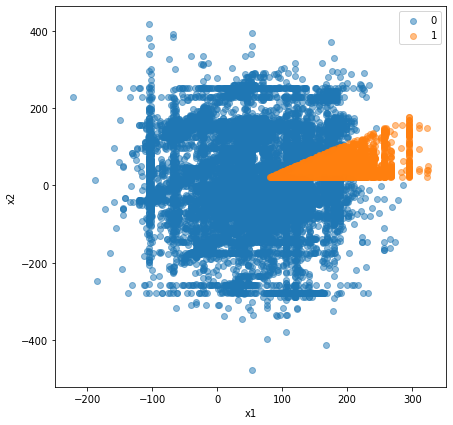

In [9]:
plot_diro2c_2d(explanation, 'x1', 'x2')

### Tree with Depth 2

In [10]:
%%time
max_depth = 2
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 13.5 ms, sys: 2.44 ms, total: 16 ms
Wall time: 16.3 ms


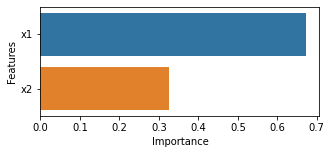

In [11]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

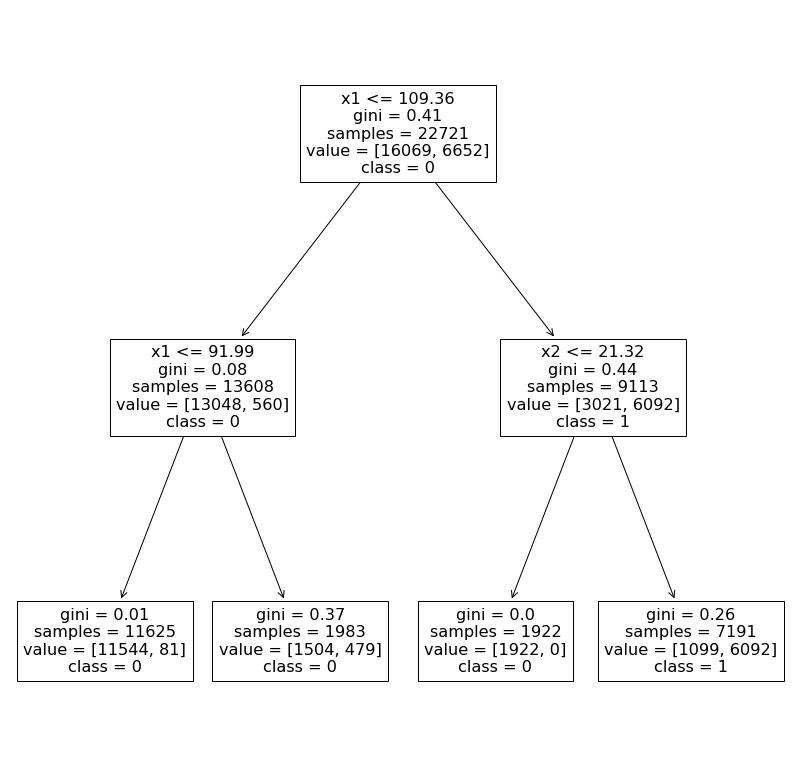

In [12]:
plot_surrogate_tree(explanation, precision=2)

In [13]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. x1 > 109.36459350585938 and x2 > 21.31893539428711 [1099, 6092]


In [14]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)

44     1
51     1
58     1
60     1
69     1
78     1
96     1
148    1
170    1
177    1
195    0
207    1
221    1
224    1
229    1
236    1
241    1
246    1
249    1
269    1
275    1
296    1
dtype: int64

In [15]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.96      0.93      0.95     16069
           1       0.85      0.92      0.88      6652

    accuracy                           0.93     22721
   macro avg       0.91      0.92      0.91     22721
weighted avg       0.93      0.93      0.93     22721



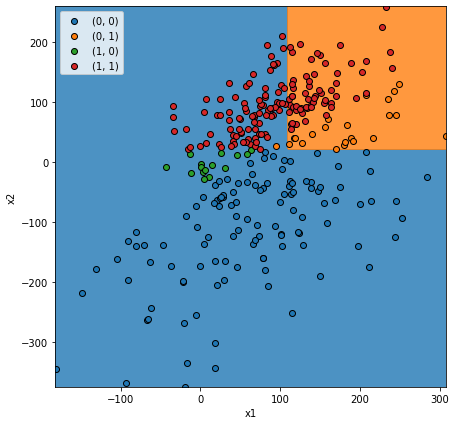

In [16]:
plot_tree_leafs_2d(explanation, comparer, X)

#### Evaluation

##### Global Fidelity

In [17]:
global_fidelities[(max_depth, focus_class)] = evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      0.78      0.88       278
           1       0.26      0.95      0.40        22

    accuracy                           0.79       300
   macro avg       0.63      0.87      0.64       300
weighted avg       0.94      0.79      0.84       300



##### Counterfactual Fidelity Error

In [18]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule,
                                                      constraints)

In [19]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
x1,48.687043,0.0,0.0
x2,0.031510,0.5,0.0


##### Complexity

In [20]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules          1
Constraints    2
dtype: int64

### Tree with Depth 3

In [21]:
%%time
max_depth = 3
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 17.8 ms, sys: 10.3 ms, total: 28.1 ms
Wall time: 47.7 ms


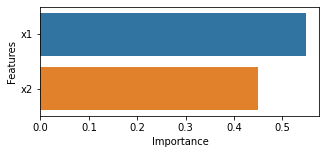

In [22]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

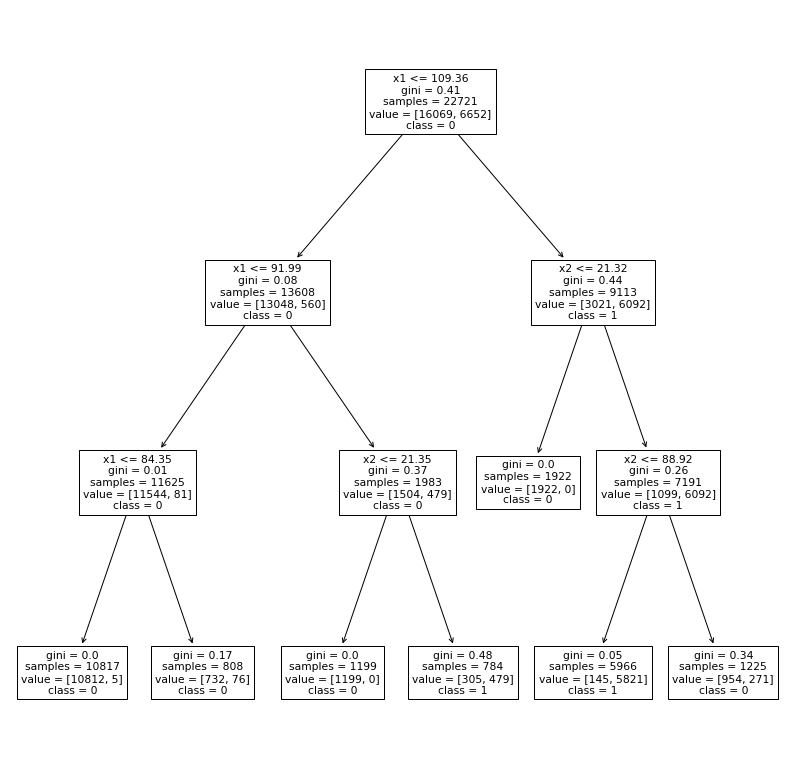

In [23]:
plot_surrogate_tree(explanation, precision=2)

In [24]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. x1 > 109.36459350585938 and 21.31893539428711 < x2 <= 88.91662979125977 [145, 5821]
2. 91.99395751953125 < x1 <= 109.36459350585938 and x2 > 21.349777221679688 [305, 479]


In [25]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)

44     1
51     1
58     1
60     1
69     1
78     1
96     1
148    1
170    1
177    1
195    2
207    1
221    1
224    1
229    0
236    0
241    1
246    1
249    0
269    1
275    0
296    1
dtype: int64

In [26]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     16069
           1       0.93      0.95      0.94      6652

    accuracy                           0.96     22721
   macro avg       0.96      0.96      0.96     22721
weighted avg       0.96      0.96      0.96     22721



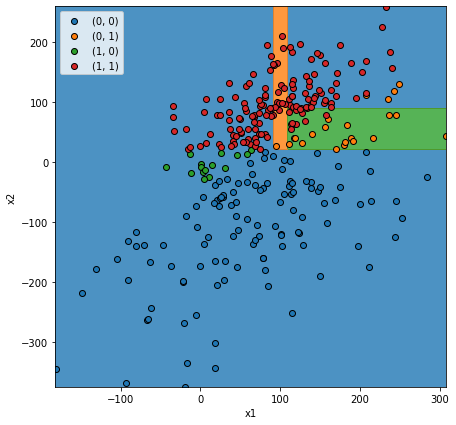

In [27]:
plot_tree_leafs_2d(explanation, comparer, X)

#### Evaluation

##### Global Fidelity

In [28]:
global_fidelities[(max_depth, focus_class)] = evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       278
           1       0.43      0.82      0.56        22

    accuracy                           0.91       300
   macro avg       0.71      0.87      0.76       300
weighted avg       0.94      0.91      0.92       300



##### Counterfactual Fidelity Error

In [29]:
errors, statistics = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [30]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
x1,22.782058,0.000000,0.052632
x2,26.051173,0.027778,0.000000


##### Complexity

In [31]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules          2
Constraints    6
dtype: int64

### Tree with Depth 4

In [32]:
%%time
max_depth = 4
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 18.9 ms, sys: 7.91 ms, total: 26.8 ms
Wall time: 27.9 ms


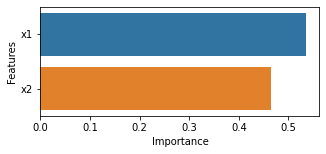

In [33]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

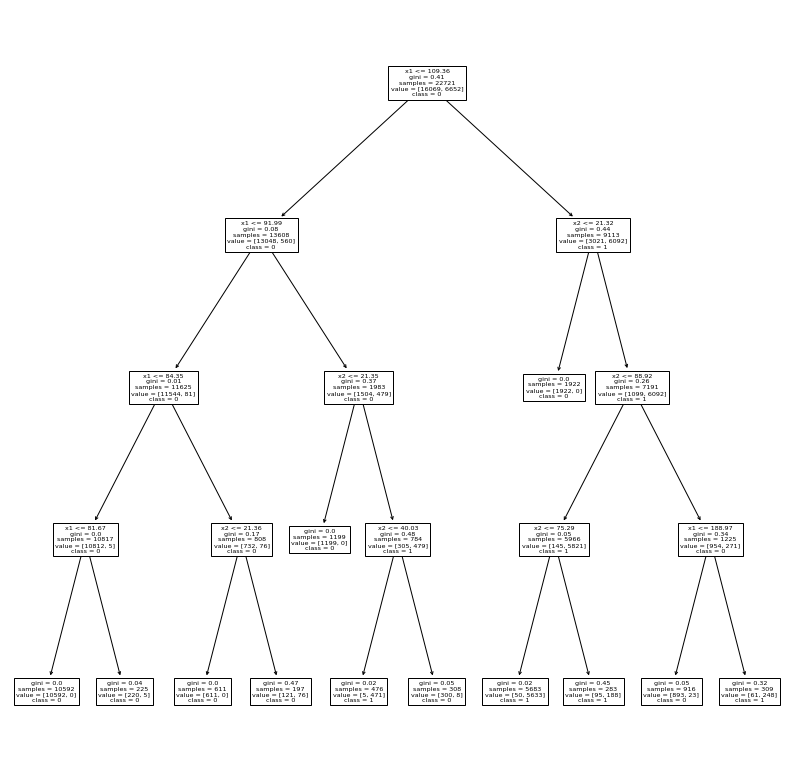

In [34]:
plot_surrogate_tree(explanation, precision=2)

In [35]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. x1 > 109.36459350585938 and 21.31893539428711 < x2 <= 75.28904342651367 [50, 5633]
2. 91.99395751953125 < x1 <= 109.36459350585938 and 21.349777221679688 < x2 <= 40.025299072265625 [5, 471]
3. x1 > 188.96837615966797 and x2 > 88.91662979125977 [61, 248]
4. x1 > 109.36459350585938 and 75.28904342651367 < x2 <= 88.91662979125977 [95, 188]


In [36]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

44     1
51     1
58     4
60     1
69     1
78     1
96     1
148    1
170    1
177    1
195    2
207    1
221    1
224    1
229    3
236    3
241    1
246    4
249    3
269    1
275    3
296    1
dtype: int64

In [37]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. x1 > 109.36459350585938 and 21.31893539428711 < x2 <= 75.28904342651367 [50, 5633]
2. 91.99395751953125 < x1 <= 109.36459350585938 and 21.349777221679688 < x2 <= 40.025299072265625 [5, 471]
3. x1 > 188.96837615966797 and x2 > 88.91662979125977 [61, 248]
4. x1 > 109.36459350585938 and 75.28904342651367 < x2 <= 88.91662979125977 [95, 188]


In [38]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     16069
           1       0.97      0.98      0.98      6652

    accuracy                           0.99     22721
   macro avg       0.98      0.99      0.98     22721
weighted avg       0.99      0.99      0.99     22721



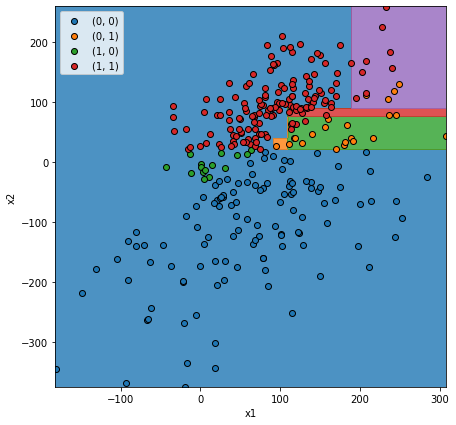

In [39]:
plot_tree_leafs_2d(explanation, comparer, X)

#### Evaluation

This explanation has higher precision (43\% to 54\%), so covers more instances classified differently, but has a higher CFE.

##### Global Fidelity

In [40]:
global_fidelities[(max_depth, focus_class)] = evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       278
           1       0.54      1.00      0.70        22

    accuracy                           0.94       300
   macro avg       0.77      0.97      0.83       300
weighted avg       0.97      0.94      0.95       300



##### Counterfactual Fidelity Error

In [41]:
errors, statistics = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [42]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
x1,22.960701,0.000000,0.043478
x2,35.336981,0.090909,0.000000


##### Complexity

In [43]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules           4
Constraints    12
dtype: int64

### Tree with Depth 5

In [44]:
%%time
max_depth = 5
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 26.3 ms, sys: 8.32 ms, total: 34.6 ms
Wall time: 44 ms


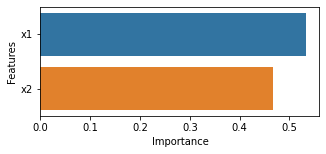

In [45]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

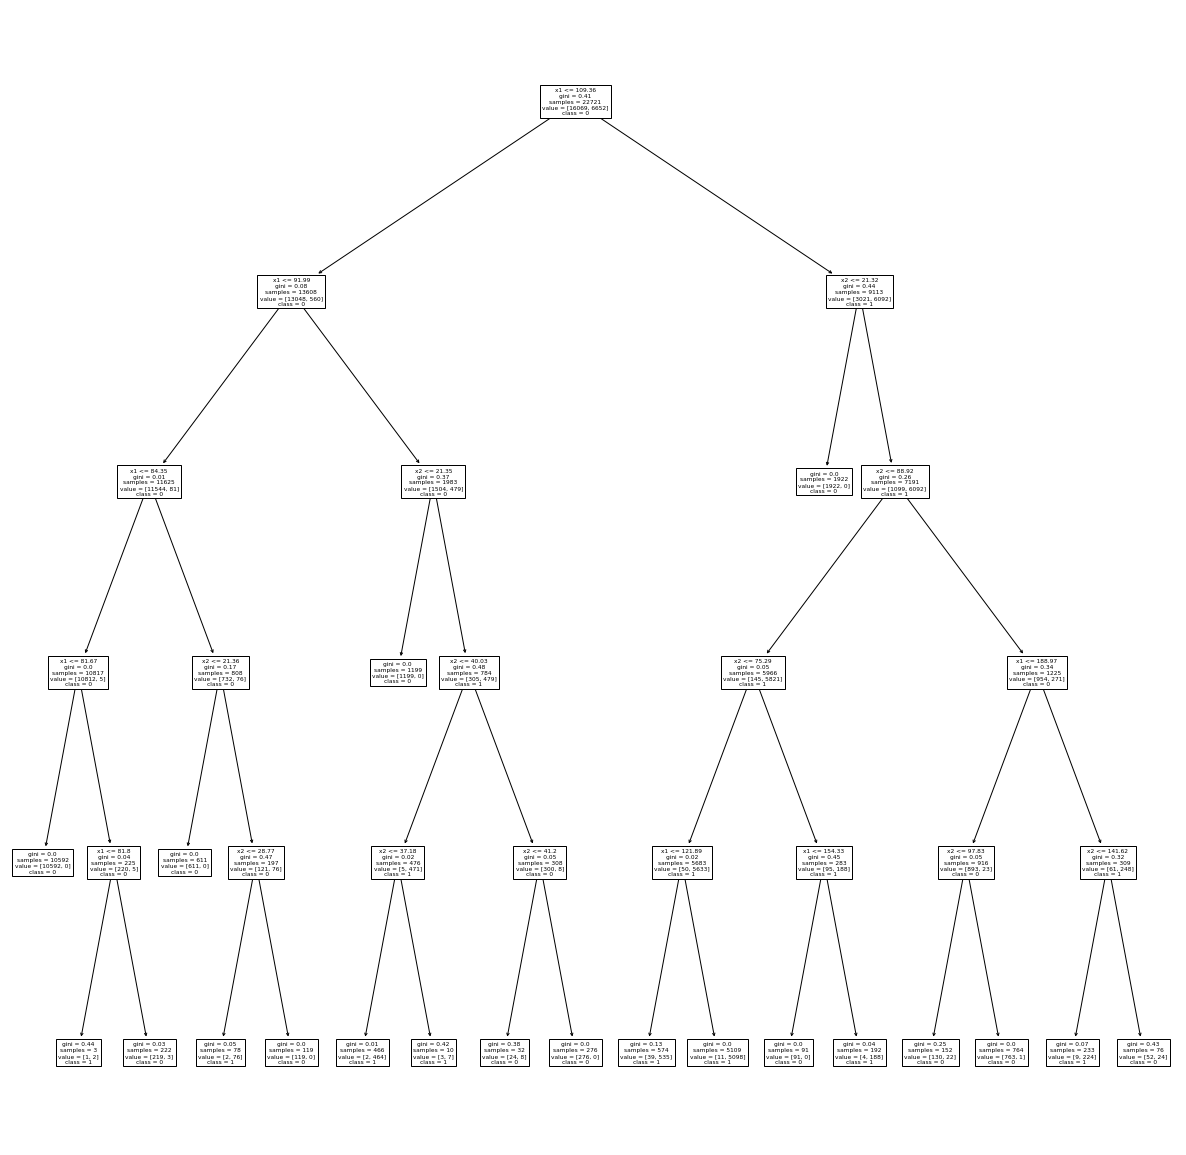

In [46]:
plot_surrogate_tree(explanation, precision=2, figsize=(21, 21))

In [47]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. x1 > 121.8860969543457 and 21.31893539428711 < x2 <= 75.28904342651367 [11, 5098]
2. 109.36459350585938 < x1 <= 121.8860969543457 and 21.31893539428711 < x2 <= 75.28904342651367 [39, 535]
3. 91.99395751953125 < x1 <= 109.36459350585938 and 21.349777221679688 < x2 <= 37.177398681640625 [2, 464]
4. x1 > 188.96837615966797 and 88.91662979125977 < x2 <= 141.62493133544922 [9, 224]
5. x1 > 154.32992553710938 and 75.28904342651367 < x2 <= 88.91662979125977 [4, 188]
6. 84.35037612915039 < x1 <= 91.99395751953125 and 21.36477565765381 < x2 <= 28.768179893493652 [2, 76]
7. 91.99395751953125 < x1 <= 109.36459350585938 and 37.177398681640625 < x2 <= 40.025299072265625 [3, 7]
8. 81.67263793945312 < x1 <= 81.79521942138672 [1, 2]


In [48]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

44     1
51     1
58     5
60     1
69     1
78     1
96     2
148    2
170    1
177    1
195    3
207    1
221    1
224    1
229    4
236    4
241    1
246    5
249    4
269    2
275    4
296    1
dtype: int64

In [49]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. x1 > 121.8860969543457 and 21.31893539428711 < x2 <= 75.28904342651367 [11, 5098]
2. 109.36459350585938 < x1 <= 121.8860969543457 and 21.31893539428711 < x2 <= 75.28904342651367 [39, 535]
3. 91.99395751953125 < x1 <= 109.36459350585938 and 21.349777221679688 < x2 <= 37.177398681640625 [2, 464]
4. x1 > 188.96837615966797 and 88.91662979125977 < x2 <= 141.62493133544922 [9, 224]
5. x1 > 154.32992553710938 and 75.28904342651367 < x2 <= 88.91662979125977 [4, 188]


In [50]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16069
           1       0.99      0.99      0.99      6652

    accuracy                           0.99     22721
   macro avg       0.99      0.99      0.99     22721
weighted avg       0.99      0.99      0.99     22721



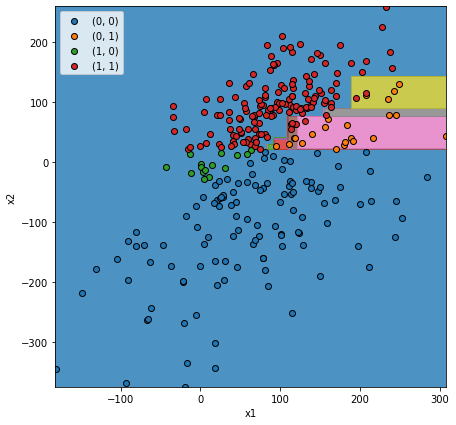

In [51]:
plot_tree_leafs_2d(explanation, comparer, X)

#### Evaluation

##### Global Fidelity

In [52]:
global_fidelities[(max_depth, focus_class)] = evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       278
           1       0.69      1.00      0.81        22

    accuracy                           0.97       300
   macro avg       0.84      0.98      0.90       300
weighted avg       0.98      0.97      0.97       300



##### Counterfactual Fidelity Error

In [53]:
errors, statistics = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [54]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
x1,19.882850,0.0,0.153846
x2,33.931441,0.0,0.000000


##### Complexity

In [55]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules           5
Constraints    17
dtype: int64

## $(1, 0)$

In [56]:
focus_class = '(1, 0)'
focus_class_idx = list(comparer.class_names).index(focus_class)

In [30]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump((explainer, explanation), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 7min 27s, sys: 5.05 s, total: 7min 32s
Wall time: 8min 7s


In [57]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explainer, explanation = pickle.load(f)

In [58]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

### Tree with Depth 2

In [59]:
%%time
max_depth = 2
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 16.8 ms, sys: 11.7 ms, total: 28.5 ms
Wall time: 49.9 ms


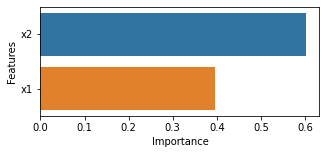

In [60]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

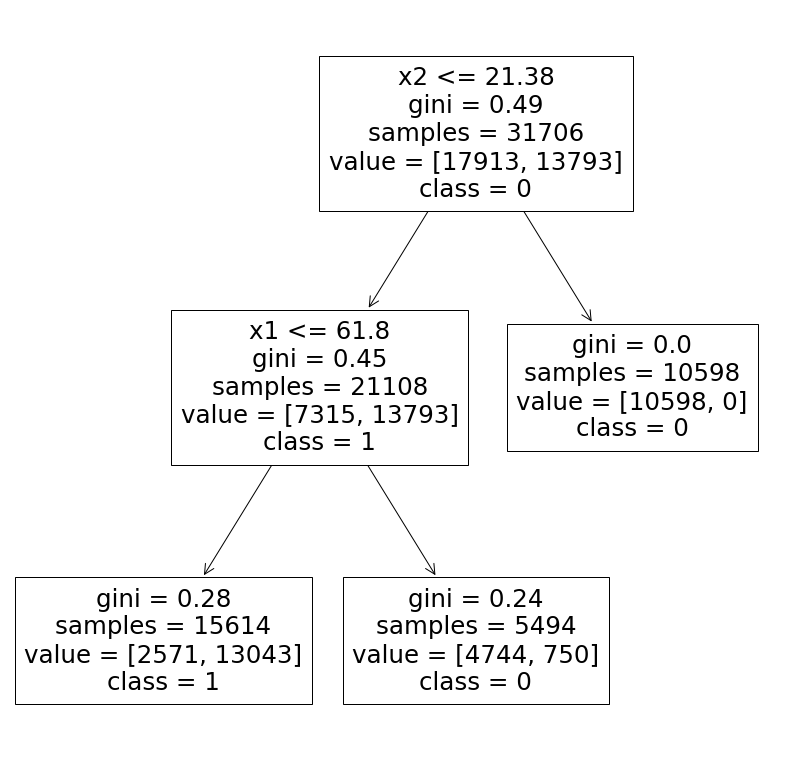

In [61]:
plot_surrogate_tree(explanation, precision=2)

In [62]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. x1 <= 61.80482482910156 and x2 <= 21.377137184143066 [2571, 13043]


In [63]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

17     1
19     1
46     1
128    0
134    1
199    1
201    1
226    1
231    1
235    1
248    1
257    1
271    1
276    1
291    1
dtype: int64

In [64]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. x1 <= 61.80482482910156 and x2 <= 21.377137184143066 [2571, 13043]


In [65]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     17913
           1       0.84      0.95      0.89     13793

    accuracy                           0.90     31706
   macro avg       0.89      0.90      0.89     31706
weighted avg       0.90      0.90      0.90     31706



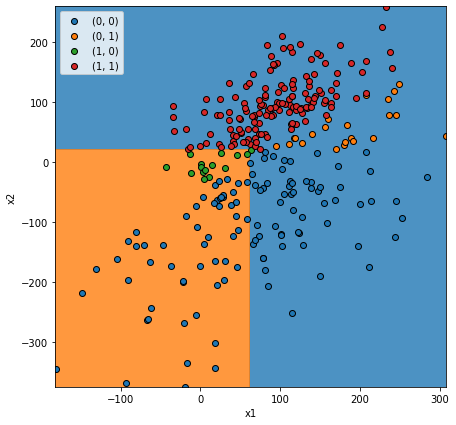

In [66]:
plot_tree_leafs_2d(explanation, comparer, X)

#### Evaluation

##### Global Fidelity

In [67]:
global_fidelities[(max_depth, focus_class)] = evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      0.81      0.89       285
           1       0.20      0.93      0.33        15

    accuracy                           0.81       300
   macro avg       0.60      0.87      0.61       300
weighted avg       0.96      0.81      0.86       300



##### Counterfactual Fidelity Error

In [68]:
errors, statistics = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [69]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
x1,26.357963,0.0,0.0
x2,0.026692,0.5,0.0


##### Complexity

In [70]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules          1
Constraints    2
dtype: int64

### Tree with Depth 3

In [71]:
%%time
max_depth = 3
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 20.8 ms, sys: 8.27 ms, total: 29.1 ms
Wall time: 44.4 ms


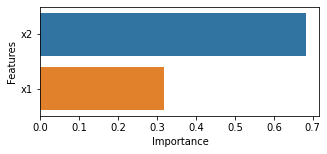

In [72]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

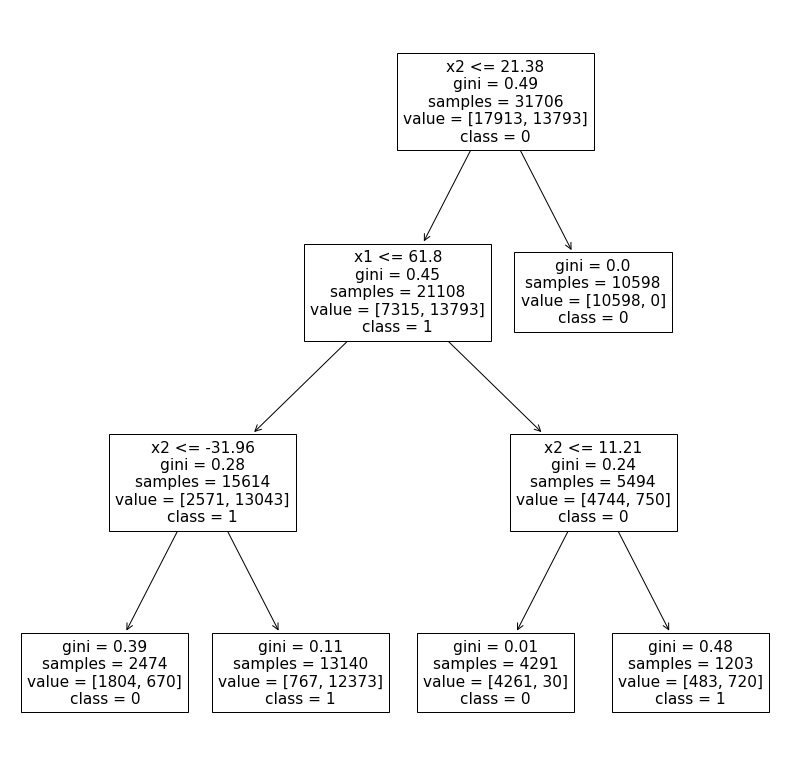

In [73]:
plot_surrogate_tree(explanation, precision=2)

In [74]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. x1 <= 61.80482482910156 and -31.95584011077881 < x2 <= 21.377137184143066 [767, 12373]
2. x1 > 61.80482482910156 and 11.214433193206787 < x2 <= 21.377137184143066 [483, 720]


In [75]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

17     1
19     1
46     1
128    2
134    1
199    1
201    1
226    1
231    1
235    1
248    1
257    1
271    1
276    1
291    1
dtype: int64

In [76]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. x1 <= 61.80482482910156 and -31.95584011077881 < x2 <= 21.377137184143066 [767, 12373]
2. x1 > 61.80482482910156 and 11.214433193206787 < x2 <= 21.377137184143066 [483, 720]


In [77]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     17913
           1       0.91      0.95      0.93     13793

    accuracy                           0.94     31706
   macro avg       0.94      0.94      0.94     31706
weighted avg       0.94      0.94      0.94     31706



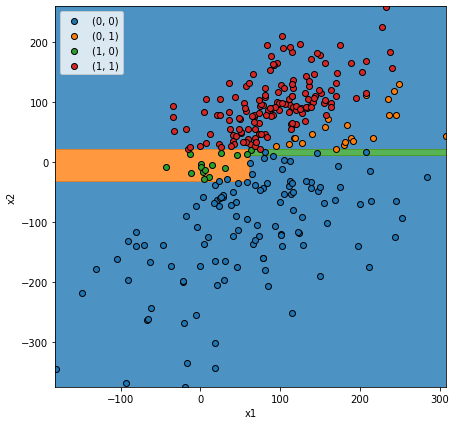

In [78]:
plot_tree_leafs_2d(explanation, comparer, X)

#### Evaluation

##### Global Fidelity

In [79]:
global_fidelities[(max_depth, focus_class)] = evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       285
           1       0.75      1.00      0.86        15

    accuracy                           0.98       300
   macro avg       0.88      0.99      0.92       300
weighted avg       0.99      0.98      0.98       300



##### Counterfactual Fidelity Error

In [80]:
errors, statistics = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [81]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
x1,26.357963,0.066667,0.066667
x2,12.469279,0.000000,0.000000


##### Complexity

In [82]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules          2
Constraints    6
dtype: int64

### Tree with Depth 4

In [83]:
%%time
max_depth = 4
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 23.7 ms, sys: 10.4 ms, total: 34.1 ms
Wall time: 36.1 ms


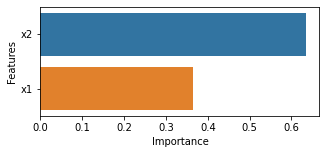

In [84]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

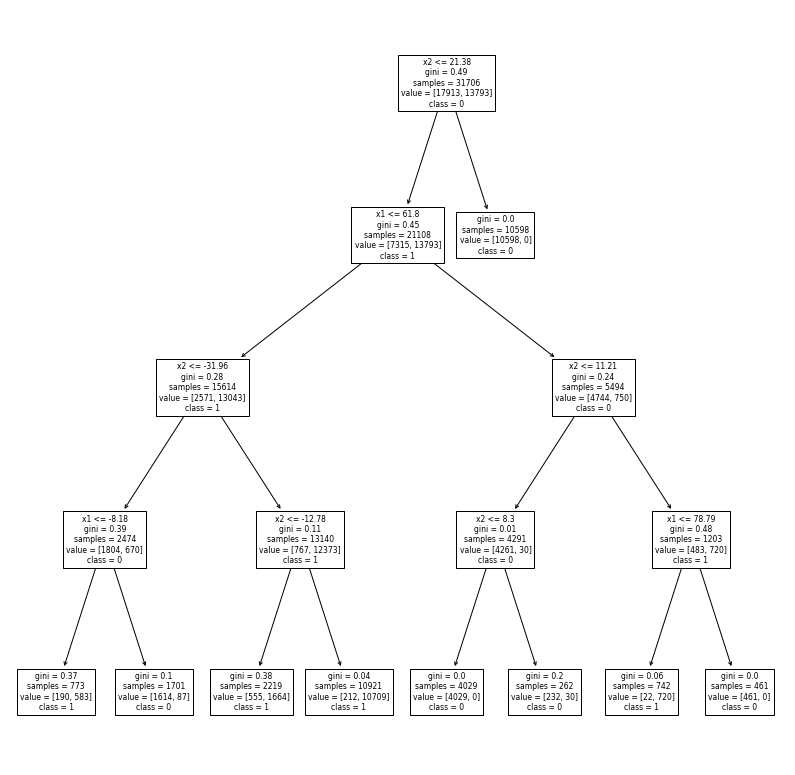

In [85]:
plot_surrogate_tree(explanation, precision=2)

In [86]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. x1 <= 61.80482482910156 and -12.77738094329834 < x2 <= 21.377137184143066 [212, 10709]
2. x1 <= 61.80482482910156 and -31.95584011077881 < x2 <= -12.77738094329834 [555, 1664]
3. x1 <= -8.175625324249268 and x2 <= -31.95584011077881 [190, 583]
4. 61.80482482910156 < x1 <= 78.79093933105469 and 11.214433193206787 < x2 <= 21.377137184143066 [22, 720]


In [87]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

17     1
19     2
46     2
128    4
134    1
199    1
201    2
226    2
231    2
235    1
248    1
257    1
271    1
276    1
291    1
dtype: int64

In [88]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. x1 <= 61.80482482910156 and -12.77738094329834 < x2 <= 21.377137184143066 [212, 10709]
2. x1 <= 61.80482482910156 and -31.95584011077881 < x2 <= -12.77738094329834 [555, 1664]
3. 61.80482482910156 < x1 <= 78.79093933105469 and 11.214433193206787 < x2 <= 21.377137184143066 [22, 720]


In [89]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     17913
           1       0.93      0.99      0.96     13793

    accuracy                           0.97     31706
   macro avg       0.96      0.97      0.97     31706
weighted avg       0.97      0.97      0.97     31706



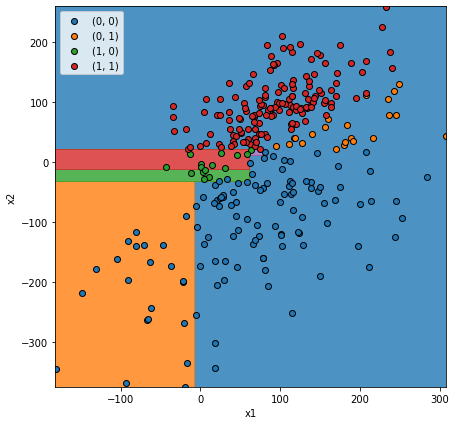

In [90]:
plot_tree_leafs_2d(explanation, comparer, X)

#### Evaluation

##### Global Fidelity

In [91]:
global_fidelities[(max_depth, focus_class)] = evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       285
           1       0.38      1.00      0.56        15

    accuracy                           0.92       300
   macro avg       0.69      0.96      0.76       300
weighted avg       0.97      0.92      0.94       300



##### Counterfactual Fidelity Error

In [92]:
errors, statistics = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [93]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
x1,25.465460,0.0,0.0625
x2,20.460799,0.0,0.0000


##### Complexity

In [94]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules           3
Constraints    10
dtype: int64

### Tree with Depth 5

In [95]:
%%time
max_depth = 5
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 24.8 ms, sys: 7.87 ms, total: 32.6 ms
Wall time: 36.9 ms


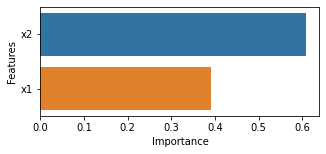

In [96]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

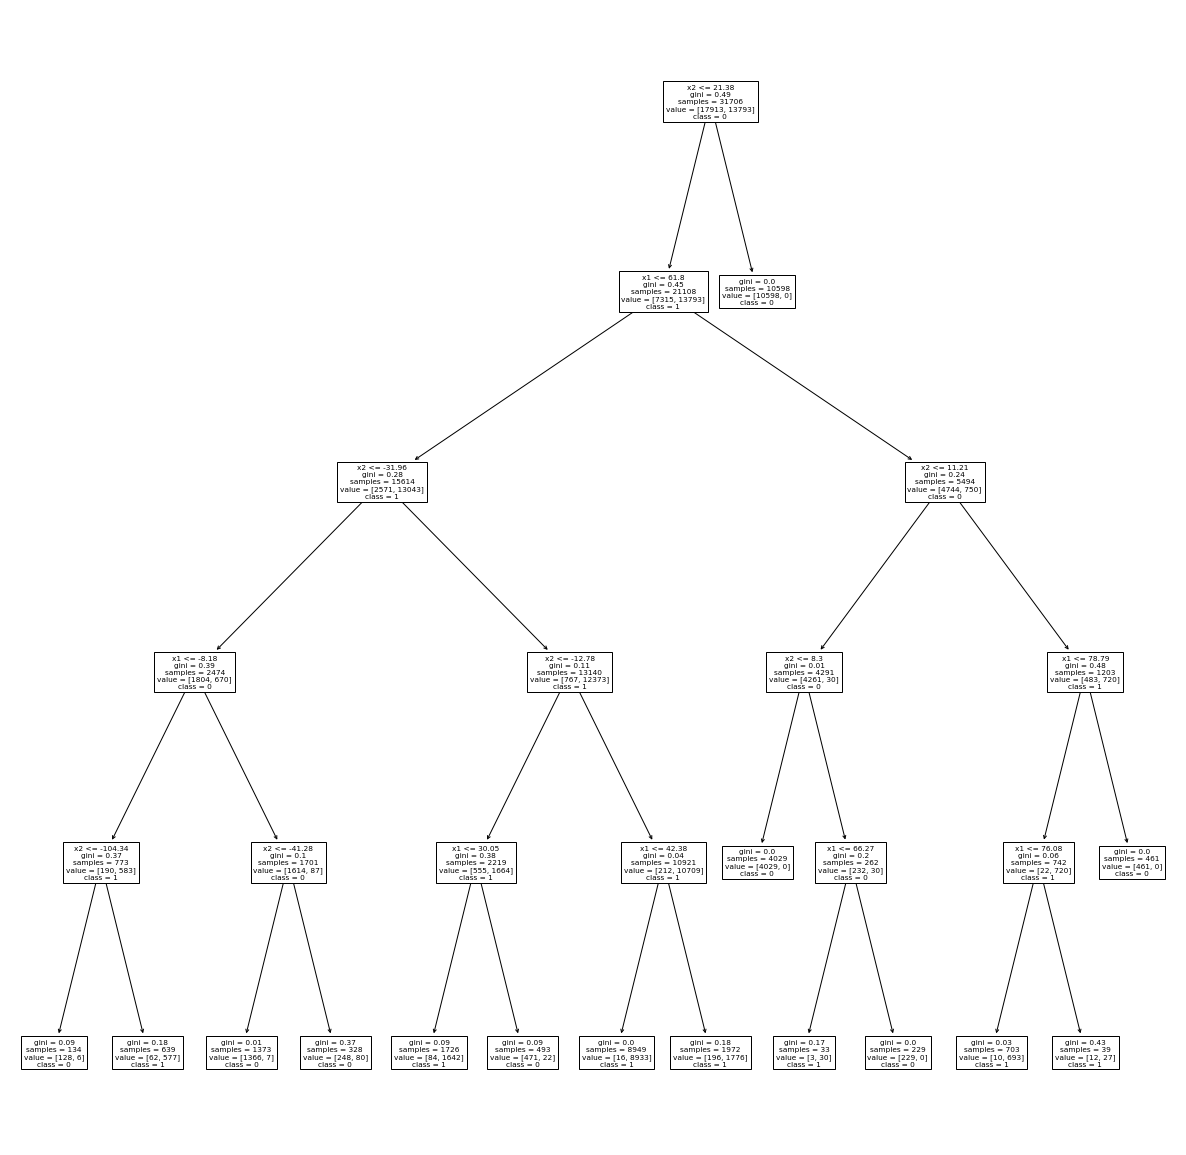

In [97]:
plot_surrogate_tree(explanation, precision=2, figsize=(21, 21))

In [98]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. x1 <= 42.37660217285156 and -12.77738094329834 < x2 <= 21.377137184143066 [16, 8933]
2. 42.37660217285156 < x1 <= 61.80482482910156 and -12.77738094329834 < x2 <= 21.377137184143066 [196, 1776]
3. x1 <= 30.048880577087402 and -31.95584011077881 < x2 <= -12.77738094329834 [84, 1642]
4. 61.80482482910156 < x1 <= 76.08122634887695 and 11.214433193206787 < x2 <= 21.377137184143066 [10, 693]
5. x1 <= -8.175625324249268 and -104.34383392333984 < x2 <= -31.95584011077881 [62, 577]
6. 76.08122634887695 < x1 <= 78.79093933105469 and 11.214433193206787 < x2 <= 21.377137184143066 [12, 27]
7. 61.80482482910156 < x1 <= 66.26707458496094 and 8.304028511047363 < x2 <= 11.214433193206787 [3, 30]


In [99]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

17     1
19     3
46     3
128    4
134    1
199    1
201    3
226    3
231    3
235    1
248    2
257    1
271    2
276    1
291    1
dtype: int64

In [100]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. x1 <= 42.37660217285156 and -12.77738094329834 < x2 <= 21.377137184143066 [16, 8933]
2. 42.37660217285156 < x1 <= 61.80482482910156 and -12.77738094329834 < x2 <= 21.377137184143066 [196, 1776]
3. x1 <= 30.048880577087402 and -31.95584011077881 < x2 <= -12.77738094329834 [84, 1642]
4. 61.80482482910156 < x1 <= 76.08122634887695 and 11.214433193206787 < x2 <= 21.377137184143066 [10, 693]


In [101]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     17913
           1       0.97      0.99      0.98     13793

    accuracy                           0.98     31706
   macro avg       0.98      0.99      0.98     31706
weighted avg       0.98      0.98      0.98     31706



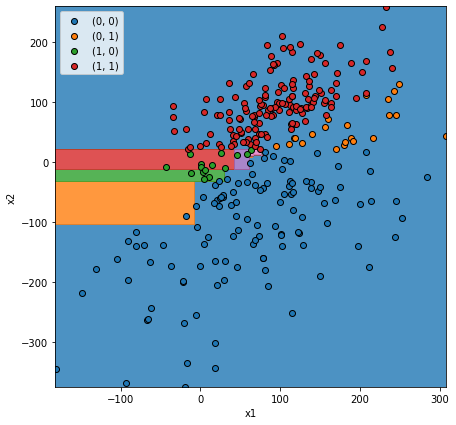

In [102]:
plot_tree_leafs_2d(explanation, comparer, X)

#### Evaluation

##### Global Fidelity

In [103]:
global_fidelities[(max_depth, focus_class)] = evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       285
           1       0.88      1.00      0.94        15

    accuracy                           0.99       300
   macro avg       0.94      1.00      0.97       300
weighted avg       0.99      0.99      0.99       300



##### Counterfactual Fidelity Error

In [104]:
errors, statistics = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [105]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
x1,12.388852,0.0,0.166667
x2,20.460799,0.0,0.000000


##### Complexity

In [106]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules           4
Constraints    14
dtype: int64

# Summary

In [120]:
def map_index(index):
    class_, depth = index[0], index[1]
    if depth == 2:
        level = 'global'
    elif depth == 5:
        level = 'local'
    else:
        level = None
    return (class_, level) if len(index) == 2 else (class_, level, index[2])

## Global Fidelity

In [117]:
global_fidelity = pd.concat(global_fidelities.values(), keys=global_fidelities.keys(), names=('depth', 'class'))
global_fidelity = global_fidelity[global_fidelity.index.get_level_values(2).astype(int) == 1]
global_fidelity.index = global_fidelity.index.droplevel(2)
global_fidelity = global_fidelity.reorder_levels(['class', 'depth']).sort_index()
global_fidelity

Precision    Recall  F1 Score  Support
class  depth                                        
(0, 1) 2       0.256098  0.954545  0.403846     22.0
       3       0.428571  0.818182  0.562500     22.0
       4       0.536585  1.000000  0.698413     22.0
       5       0.687500  1.000000  0.814815     22.0
(1, 0) 2       0.202899  0.933333  0.333333     15.0
       3       0.750000  1.000000  0.857143     15.0
       4       0.384615  1.000000  0.555556     15.0
       5       0.882353  1.000000  0.937500     15.0

## Local Fidelity

In [118]:
local_fidelity = pd.concat(local_fidelities.values(), keys=local_fidelities.keys(), names=('depth', 'class', 'feature'))
local_fidelity = local_fidelity.reorder_levels(['class', 'depth', 'feature']).sort_index()
local_fidelity

RMSE       BMR       BAR
class  depth feature                               
(0, 1) 2     x1       48.687043  0.000000  0.000000
             x2        0.031510  0.500000  0.000000
       3     x1       22.782058  0.000000  0.052632
             x2       26.051173  0.027778  0.000000
       4     x1       22.960701  0.000000  0.043478
             x2       35.336981  0.090909  0.000000
       5     x1       19.882850  0.000000  0.153846
             x2       33.931441  0.000000  0.000000
(1, 0) 2     x1       26.357963  0.000000  0.000000
             x2        0.026692  0.500000  0.000000
       3     x1       26.357963  0.066667  0.066667
             x2       12.469279  0.000000  0.000000
       4     x1       25.465460  0.000000  0.062500
             x2       20.460799  0.000000  0.000000
       5     x1       12.388852  0.000000  0.166667
             x2       20.460799  0.000000  0.000000

## Complexity

In [119]:
complexity = pd.concat(complexities.values(), axis=1, keys=complexities.keys(), names=('depth', 'class')).T
complexity = complexity.reorder_levels(['class', 'depth']).sort_index()
complexity

Rules  Constraints
class  depth                    
(0, 1) 2          1            2
       3          2            6
       4          4           12
       5          5           17
(1, 0) 2          1            2
       3          2            6
       4          3           10
       5          4           14

## Generation Time

approx. 15min.

In [124]:
global_fidelity.index = global_fidelity.index.map(map_index)
global_fidelity = global_fidelity[global_fidelity.index.get_level_values('depth').notnull()]
global_fidelity.index.rename(['class', 'level'], inplace=True)

local_fidelity.index = local_fidelity.index.map(map_index)
local_fidelity = local_fidelity[local_fidelity.index.get_level_values('depth').notnull()]
local_fidelity.index.rename(['class', 'level', 'feature'], inplace=True)

complexity.index = complexity.index.map(map_index)
complexity = complexity[complexity.index.get_level_values('depth').notnull()]
complexity.index.rename(['class', 'level'], inplace=True)

with open('results.soa.pickle', 'wb') as f:
    pickle.dump((global_fidelity, local_fidelity, complexity), f)